In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import networkx as nx
from networkx.algorithms import community
import networkx.algorithms.community as nxcom
from pyvis.network import Network

In [21]:
# download dataframe
df = pd.read_csv('polygon_daily_transactions.csv')

# Observe Data

In [22]:
# check dataframe properties
df.shape

(706763, 3)

In [24]:
# exclude form dataframe cases, when transactions were sent and received by the same address. 
df = df[df.sender_address != df.receiver_address]

Text(0.5, 1.0, 'Distribution of Transactions between Senders and Receivers')

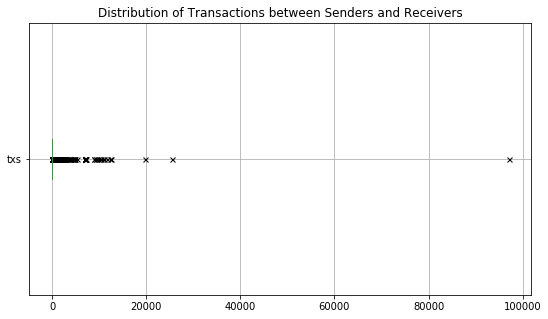

In [25]:
figure(figsize=(9, 5))
df[['txs']].boxplot(vert = False, flierprops={'marker': 'x', 'markersize': 5, 'markerfacecolor': 'lightgrey'})
plt.title('Distribution of Transactions between Senders and Receivers')

In [26]:
df.txs.describe()

count    703463.000000
mean          4.020560
std         137.097368
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       96998.000000
Name: txs, dtype: float64

In [27]:
# check if there are senders in receivers and vice versa
receiver_list = list(df.receiver_address)
df_check = df.query('sender_address in @receiver_list')
len(df_check)

209514

In [28]:
sender_list = list(df.sender_address)
df_check = df.query('receiver_address in @sender_list')
len(df_check)

119288

# Generate graph

In [29]:
# Create graph and check the description
G = nx.from_pandas_edgelist(df, 'sender_address', 'receiver_address')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 416165
Number of edges: 697292
Average degree:   3.3510


## Define Sample

In [30]:
# Get the amount of transactions received by the address
df_grouped = df.groupby('receiver_address').agg({'txs': 'sum'})
# Filter on receivers with defined amount of transactions
df_grouped[df_grouped.txs == 29].head(10)

,txs
receiver_address,
0x05da6c1948f4087dd04d97b0106583963cfa559d,29
0x09a84f900205b1ac5f3214d3220c7317fd5f5b77,29
0x16625b9ff0f12952b3a9b048aaba4ac4229b2f9a,29
0x219a9a3f773712fad225f6b33b00460aec93dbde,29
0x225392dbb7f99ed1f97ea4fabb845d729c94f2ea,29
0x231b0d272d5ff3a9b47d971fb6b1cac2f149a8ae,29
0x337e35068d854c0259f71b4dc7373cd1ddbb36e9,29
0x3415792e31e88c79c53d5e488d6ff4634f8c412e,29
0x37ba5291a5be8cbe44717a0673fe2c5a45b4b6a8,29


In [41]:
# Get list of senders, who interacted with this receiver
receiver_address = '0x09a84f900205b1ac5f3214d3220c7317fd5f5b77'
senders = list(df.sender_address[df.receiver_address == receiver_address])
# Define what is dataframe size, which is filtered on senders
len(df[df.sender_address.isin(senders)])

21

In [42]:
# Create filtered dataframe
df_address = df[df.sender_address.isin(senders)].sort_values(by = 'txs', ascending = False)

In [43]:
# check if there are senders in receivers and vice versa
receiver_list = list(df_address.receiver_address)
df_check = df_address.query('sender_address in @receiver_list')
df_check

,sender_address,receiver_address,txs
560790,0x403cc1e7a756c440e82596ed2e78798aadf4012d,0x09a84f900205b1ac5f3214d3220c7317fd5f5b77,2
105994,0x954bdebfd4aa623c66ad8a53747cae437339b455,0x09a84f900205b1ac5f3214d3220c7317fd5f5b77,2
541432,0x954bdebfd4aa623c66ad8a53747cae437339b455,0x403cc1e7a756c440e82596ed2e78798aadf4012d,1
139671,0x2b24a02ece96980dcb45deca18ce1ce84490f8c7,0x09a84f900205b1ac5f3214d3220c7317fd5f5b77,1


In [44]:
sender_list = list(df_address.sender_address)
df_check = df_address.query('receiver_address in @sender_list')
df_check

,sender_address,receiver_address,txs
541432,0x954bdebfd4aa623c66ad8a53747cae437339b455,0x403cc1e7a756c440e82596ed2e78798aadf4012d,1
484406,0x0b426e0c7e56a98e500816f6ac5cf1c027c6e2f1,0x954bdebfd4aa623c66ad8a53747cae437339b455,1
236553,0xc395a7982ecb5586e1f655caab32dc0217d50bc1,0x2b24a02ece96980dcb45deca18ce1ce84490f8c7,1


In [45]:
df_address.shape

(21, 3)

## Identify Communities

In [256]:
# generate graph from filtered dataframe
G_address = nx.from_pandas_edgelist(df_address,'sender_address', 'receiver_address')

In [231]:
# Find the communities
communities = sorted(nxcom.greedy_modularity_communities(G_address), key=len, reverse=True)
# Count the communities
print(f"{receiver_address} based network has {len(communities)} communities.")

0x09a84f900205b1ac5f3214d3220c7317fd5f5b77 based network has 3 communities.


In [232]:
communities_generator = community.girvan_newman(G_address)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
print(f"{receiver_address} based network has {len(next_level_communities)} communities.")

0x09a84f900205b1ac5f3214d3220c7317fd5f5b77 based network has 3 communities.


In [233]:
communities_list = sorted(map(sorted, next_level_communities))
communities_list

[['0x09a84f900205b1ac5f3214d3220c7317fd5f5b77',
  '0x0b68b6c5b1d8e9f209b29519fafd455bfe7e7f55',
  '0x674bec71176f49771fb87324a2ff0fae2221f45c',
  '0x8766e0167e95b7de376644c0be62c0d17641e81d',
  '0x8dff8538700737974152140c0c3be114e22ad296',
  '0x9a7c4815656b33bf32192e5c3fd102b90d5b9f34',
  '0xe305e6e9917cfd79c4634fd5a3022f995c6e65f7',
  '0xfc8ce27a58d5dad08d52b5d339b7cf65458f2f85',
  '0xfdb3dfec142042839ad7c3dab5c8b801904addb4'],
 ['0x0b426e0c7e56a98e500816f6ac5cf1c027c6e2f1',
  '0x403cc1e7a756c440e82596ed2e78798aadf4012d',
  '0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45',
  '0x954bdebfd4aa623c66ad8a53747cae437339b455'],
 ['0x1a1ec25dc08e98e5e93f1104b5e5cdd298707d31',
  '0x2b24a02ece96980dcb45deca18ce1ce84490f8c7',
  '0x5336dd2ef8fa4526200c34da275622b98a22b28e',
  '0xc395a7982ecb5586e1f655caab32dc0217d50bc1',
  '0xd50cebb8531047ba089f7266bb9e9ee65366f681']]

# Visualisation

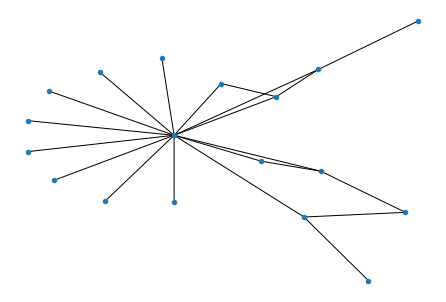

<Figure size 648x576 with 0 Axes>

In [234]:
nx.draw_spring(G_address, 
               node_size=20)
figure(figsize=(9, 8))
plt.show()

## Matplotlib

### Color Nodes

In [275]:
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
# Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

In [276]:
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

In [277]:
 def get_color(i, r_off=1, g_off=1, b_off=1):
        '''Assign a color to a vertex.'''
        r0, g0, b0 = 0, 0, 0
        n = 16
        low, high = 0.01, 0.99
        span = high - low
        r = low + span * (((i + r_off) * 3) % n) / (n - 1)
        g = low + span * (((i + g_off) * 5) % n) / (n - 1)
        b = low + span * (((i + b_off) * 7) % n) / (n - 1)
        return (r, g, b)
# Source: https://graphsandnetworks.com/community-detection-using-networkx/

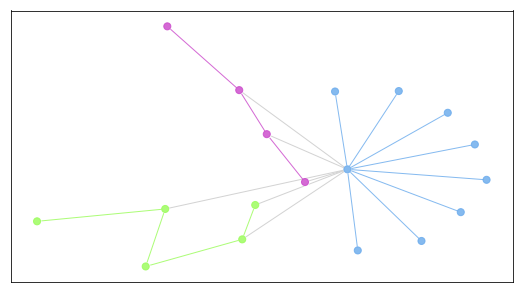

In [312]:
figure(figsize=(9, 5))

# Set node and edge communities
set_node_community(G_address, communities)
set_edge_community(G_address)

# Set community color for nodes
node_color = [get_color(G_address.nodes[v]['community']) for v in G_address.nodes]

# Set community color for internal edges
external = [(v, w) for v, w in G_address.edges if G_address.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G_address.edges if G_address.edges[v, w]['community'] > 0]
internal_color = [get_color(G_address.edges[e]['community']) for e in internal]

chart_pos = nx.spring_layout(G_address)

# Draw external edges

##draw_networkx
nx.draw_networkx(
        G_address, pos=chart_pos, node_size=50, node_color = 'white',
        edgelist=external, edge_color="lightgrey", with_labels=False)
# Draw nodes and internal edges
nx.draw_networkx(
        G_address, pos=chart_pos, node_color=node_color, alpha = 0.8, node_size=50,
        edgelist=internal, edge_color=internal_color, with_labels=False)

### Directed Graph

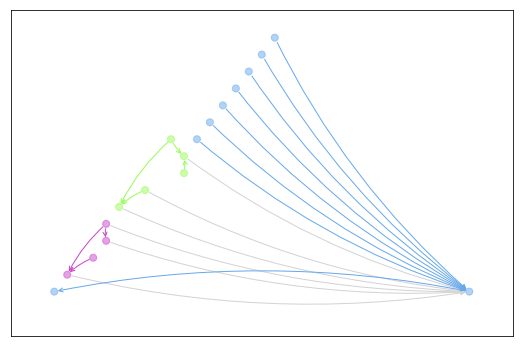

In [314]:
figure(figsize=(9, 6))

G_directed = nx.MultiDiGraph()
edge_list = zip(df_address.sender_address, df_address.receiver_address)
G_directed.add_edges_from(edge_list)
G_directed.add_nodes_from(edge_list)

external = [(w, v) for v, w in G_address.edges if G_address.edges[v, w]['community'] == 0]
internal = [(w, v) for v, w in G_address.edges if G_address.edges[v, w]['community'] > 0]

# chart_pos = nx.spring_layout(G_address)
chart_pos = nx.planar_layout(G_directed)
# Draw external edges

##draw_networkx
nx.draw_networkx(
        G_directed, 
        pos=chart_pos, 
        node_size=50, 
        node_color = 'white',
        edgelist=external, 
        edge_color="lightgrey", 
        with_labels=False,
            connectionstyle='arc3, rad = 0.1',
            arrowsbool = True,
            arrowstyle = '->',
            head_width = 10)
# Draw nodes and internal edges
nx.draw_networkx(
        G_directed, 
        pos=chart_pos, 
        node_color=node_color, 
        alpha = 0.5, 
        node_size=50,
        edgelist=internal, 
        edge_color=internal_color, 
        with_labels=False,
            connectionstyle='arc3, rad = 0.1',
            arrowsbool = False,
            arrowstyle = '->')

## Pyvis

In [317]:
# Example 1: Not Directed Graph
net = Network(notebook=True, 
              height="750px", 
              width="100%", 
              select_menu=True,
             cdn_resources='remote') 

senders = df_address.groupby('sender_address').txs.sum().to_dict()
receivers = df_address.groupby('receiver_address').txs.sum().to_dict()

def add_node(d, col1, col2, shape = 'dot', size = 10):
    for k, v in d.items():
        if v == 1:
            net.add_node(k, k, title=k, color= col1, shape = shape, size = size)
        else:
            net.add_node(k, k, title=k, color=col2, shape = shape, size = size)
            
add_node(senders, '#ff6f69', '#d96459')          
add_node(receivers, '#96ceb4', '#588c7e', shape = 'star', size = 20)

edge_list = list(zip(df_address.iloc[:,0:2].sender_address, df_address.iloc[:,0:2].receiver_address))
net.add_edges(edge_list)
net.repulsion()
net.show_buttons(filter_=['physics'])
net.show("example2.html")

In [324]:
# Example 2: Directed Graph
net = Network(notebook=True, 
              height="750px", 
              width="100%", 
              filter_menu=True,
              directed = True,
              select_menu=True,
             cdn_resources='remote') 

senders = df_address.groupby('sender_address').txs.sum().to_dict()
receivers = df_address.groupby('receiver_address').txs.sum().to_dict()

def add_node(d, col1, col2, shape = 'dot', size = 10):
    for k, v in d.items():
        if v == 1:
            net.add_node(k, k, title=k, color= col1, shape = shape, size = size)
        else:
            net.add_node(k, k, title=k, color=col2, shape = shape, size = size)
            
add_node(senders, '#ff6f69', '#d96459')          
add_node(receivers, '#96ceb4', '#588c7e', shape = 'star', size = 20)

edge_list = list(zip(df_address.iloc[:,0:2].sender_address, df_address.iloc[:,0:2].receiver_address))
net.add_edges(edge_list)
net.repulsion()
net.show_buttons(filter_=['physics'])
net.show("polygon2.html")